In [1]:
# 分析时间：2012年1月1日-2022年12月31日，总共11年时间
start_date_str = "2012-01-01"
end_date_str = "2022-12-31"

In [2]:

import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics
import QuantLib as ql
%matplotlib inline



In [3]:
import warnings


warnings.simplefilter("ignore")

plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

%config InlineBackend.figure_format = 'retina'

In [4]:
# 加载nelson siegel svensson模型代码
%run ../src/nelson_siegel_svensson/__init__.py
%run ../src/nelson_siegel_svensson/calibrate.py
%run ../src/nelson_siegel_svensson/cli.py
%run ../src/nelson_siegel_svensson/ns.py
%run ../src/nelson_siegel_svensson/nss.py

Usage: cli.py [OPTIONS] COMMAND [ARGS]...

  Commandline interface for nelson_siegel_svensson.

Options:
  --help  Show this message and exit.

Commands:
  calibrate  Calibrate a curve to the given data points.
  evaluate   Evaluate a curve at given points.
  plot       Plot a curve at given points.


## 1.数据处理

In [5]:
# 到期收益率
raw_yield_to_maturity_df = pd.read_excel('./data/国债到期收益率.xlsx')
raw_yield_to_maturity_df = raw_yield_to_maturity_df.rename(columns={'指标名称': 'Date',
       '国债到期收益率:6个月': "6M", '国债到期收益率:1年': "1Y", '国债到期收益率:2年': "2Y", '国债到期收益率:3年': "3Y",
       '国债到期收益率:4年': "4Y", '国债到期收益率:5年': "5Y", '国债到期收益率:6年': "6Y", '国债到期收益率:7年': "7Y", 
        '国债到期收益率:8年': "8Y",'国债到期收益率:9年': "9Y", '国债到期收益率:10年': "10Y", '国债到期收益率:15年': "15Y", 
        '国债到期收益率:20年': "20Y", '国债到期收益率:30年': "30Y"})
raw_yield_to_maturity_df

,Date,6M,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y,10Y,15Y,20Y,30Y
0,2008-07-01,3.2769,3.4474,3.8065,4.0301,4.1697,4.3093,4.3498,4.3903,4.4292,4.4682,4.5072,4.9618,4.9639,4.9498
1,2008-07-02,3.4055,3.5461,3.8015,3.9506,4.0883,4.2260,4.3019,4.3778,4.4282,4.4787,4.5291,4.9442,4.9462,4.9501
2,2008-07-03,3.3343,3.4972,3.8687,3.9820,4.1085,4.2350,4.3163,4.3976,4.4436,4.4896,4.5356,4.9453,4.9469,4.9501
3,2008-07-04,3.3397,3.4763,3.8179,3.9854,4.1031,4.2209,4.3183,4.4157,4.4618,4.5080,4.5542,4.9469,4.9479,4.9501
4,2008-07-07,3.3679,3.4796,3.8138,3.9561,4.0850,4.2140,4.2849,4.3559,4.4215,4.4871,4.5527,4.9226,4.9285,4.9404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3667,2023-03-13,2.1958,2.2696,2.4373,2.5289,2.6127,2.6965,2.7655,2.8345,2.8473,2.8600,2.8728,3.0310,3.1147,3.2772
3668,2023-03-14,2.1950,2.2655,2.4475,2.5215,2.6046,2.6877,2.7591,2.8305,2.8417,2.8528,2.8640,3.0196,3.1047,3.2692
3669,2023-03-15,2.2050,2.2638,2.4432,2.5278,2.6121,2.6963,2.7663,2.8363,2.8474,2.8584,2.8695,3.0152,3.1033,3.2700
3670,2023-03-16,2.1799,2.2598,2.4193,2.5182,2.5953,2.6723,2.7483,2.8242,2.8342,2.8441,2.8541,2.9998,3.0857,3.2503


In [6]:
raw_yield_to_maturity_df.columns

Index(['Date', '6M', '1Y', '2Y', '3Y', '4Y', '5Y', '6Y', '7Y', '8Y', '9Y',
       '10Y', '15Y', '20Y', '30Y'],
      dtype='object')

In [7]:
start_date = datetime.datetime.strptime(start_date_str, "%Y-%m-%d")
end_date = datetime.datetime.strptime(end_date_str, "%Y-%m-%d")
print(start_date, end_date)

2012-01-01 00:00:00 2022-12-31 00:00:00


In [8]:
yield_to_maturity_df = raw_yield_to_maturity_df[(raw_yield_to_maturity_df['Date']>=start_date)
                                                & (raw_yield_to_maturity_df['Date']<=end_date)].reset_index(drop=True)

## 2.用QuantLib构建因子

In [9]:
test_date_str = "2013-01-08"
test_date =  datetime.datetime.strptime(test_date_str, "%Y-%m-%d")

In [10]:

def get_factor_use_quantlib(test_date, yield_to_maturity_df):
    # 将利率期限转换为quantlib能够识别的类型
    tenor_list = ['6M', '1Y', '2Y', '3Y', '4Y', '5Y', '6Y', '7Y', 
                  '8Y', '9Y', '10Y', '15Y', '20Y', '30Y']
    ql_tenor_list = [ql.Period(6, ql.Months), ql.Period(1, ql.Years), ql.Period(2, ql.Years),
                    ql.Period(3, ql.Years), ql.Period(4, ql.Years), ql.Period(5, ql.Years),
                    ql.Period(6, ql.Years), ql.Period(7, ql.Years), ql.Period(8, ql.Years),
                    ql.Period(9, ql.Years), ql.Period(10, ql.Years), ql.Period(15, ql.Years),
                    ql.Period(20, ql.Years), ql.Period(30, ql.Years)]

    maturities = [0.50, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30]
    ytm_list = yield_to_maturity_df[yield_to_maturity_df['Date']==test_date][tenor_list].values.tolist()[0]
    ytm_list = [var/100 for var in ytm_list]
    numberOfBonds = len(maturities)
    cleanPrice = [100.0] * numberOfBonds
    quote = [ql.SimpleQuote(c) for c in cleanPrice]

    quoteHandle = [ql.QuoteHandle(q) for q in quote]

    frequency = ql.Annual
    dc = ql.ActualActual(ql.ActualActual.ISMA)
    accrualConvention = ql.ModifiedFollowing
    convention = ql.ModifiedFollowing
    redemption = 100.0
    calendar = ql.China(ql.China.IB)

    today = calendar.adjust(ql.Date(test_date.day, test_date.month, test_date.year))
    ql.Settings.instance().evaluationDate = today

    bondSettlementDays = 0
    bondSettlementDate = calendar.advance(today, ql.Period(bondSettlementDays, ql.Days))

    instruments = []

    for j in range(len(maturities)):
        temp_maturity_value = maturities[j]
        temp_ql_maturity_value = None
        if temp_maturity_value <1:
            temp_ql_maturity_value = ql.Period(int(temp_maturity_value * 12), ql.Months)
        else:
            temp_ql_maturity_value = ql.Period(int(temp_maturity_value), ql.Years)
        maturity = calendar.advance(bondSettlementDate,temp_ql_maturity_value)
        schedule = ql.Schedule(bondSettlementDate,
                              maturity,
                              ql.Period(frequency),
                              calendar,
                              accrualConvention,
                              accrualConvention,
                              ql.DateGeneration.Backward,
                              False)
        helper = ql.FixedRateBondHelper(quoteHandle[j],
                                       bondSettlementDays,
                                       100.0,
                                       schedule,
                                       [ytm_list[j]],
                                       dc,
                                       convention,
                                       redemption)
        instruments.append(helper)

    tolerance = 1.0e-10
    max = 5000
    #svensson = ql.SvenssonFitting()
    ns = ql.NelsonSiegelFitting()
    curve = ql.FittedBondDiscountCurve(
            bondSettlementDate,
            instruments,
            dc,
            ns,
            tolerance,
            max)
    return curve

quantlib_curve =  get_factor_use_quantlib(test_date, yield_to_maturity_df)
quantlib_curve

<QuantLib.QuantLib.FittedBondDiscountCurve; proxy of <Swig Object of type 'ext::shared_ptr< FittedBondDiscountCurve > *' at 0x00000249883C5B30> >

In [11]:
ql_solution = quantlib_curve.fitResults().solution()
ql_factor_list = [var for var in ql_solution]
ql_factor_list

[-2509.7689562265073,
 2509.7969331993236,
 2499.911228487047,
 -0.00018815472787489396]

## 3.用源码构建因子


In [12]:
def build_ns_curve(test_date, yield_to_maturity_df):
    time_list = [0.50, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30]
    tenor_list = ['6M', '1Y', '2Y', '3Y', '4Y', '5Y', '6Y', '7Y', 
                  '8Y', '9Y', '10Y', '15Y', '20Y', '30Y']
    ytm_list = yield_to_maturity_df[yield_to_maturity_df['Date']==test_date][tenor_list].values.tolist()[0]
    ytm_list = [var/100 for var in ytm_list]
    t = np.array(time_list)
    y = np.array(ytm_list)
    curve, status = calibrate_ns_ols(t, y, tau0=1.0)
    return curve, status

curve, status = build_ns_curve(test_date, yield_to_maturity_df)

In [13]:
curve

NelsonSiegelCurve(beta0=0.045619210956183556, beta1=-0.017531883573802892, beta2=-0.007232817208157015, tau=0.20792289668363717)

In [14]:
curve.tau

0.20792289668363717

## 4.确定lambda的值

In [15]:

lambda_value_list = []
for i in range(yield_to_maturity_df.shape[0]):
    temp_date = yield_to_maturity_df['Date'][i]
    time_list = [0.50, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30]
    tenor_list = ['6M', '1Y', '2Y', '3Y', '4Y', '5Y', '6Y', '7Y', 
                  '8Y', '9Y', '10Y', '15Y', '20Y', '30Y']
    #time_list = [3]
    #tenor_list = ["3Y"]
    ytm_list = yield_to_maturity_df[yield_to_maturity_df['Date']==temp_date][tenor_list].values.tolist()[0]
    ytm_list = [var/100 for var in ytm_list]
    t = np.array(time_list)
    y = np.array(ytm_list)
    curve, status = calibrate_ns_ols(t, y, tau0=1.0)
    lambda_value = curve.tau
    lambda_value_list.append(lambda_value)
     

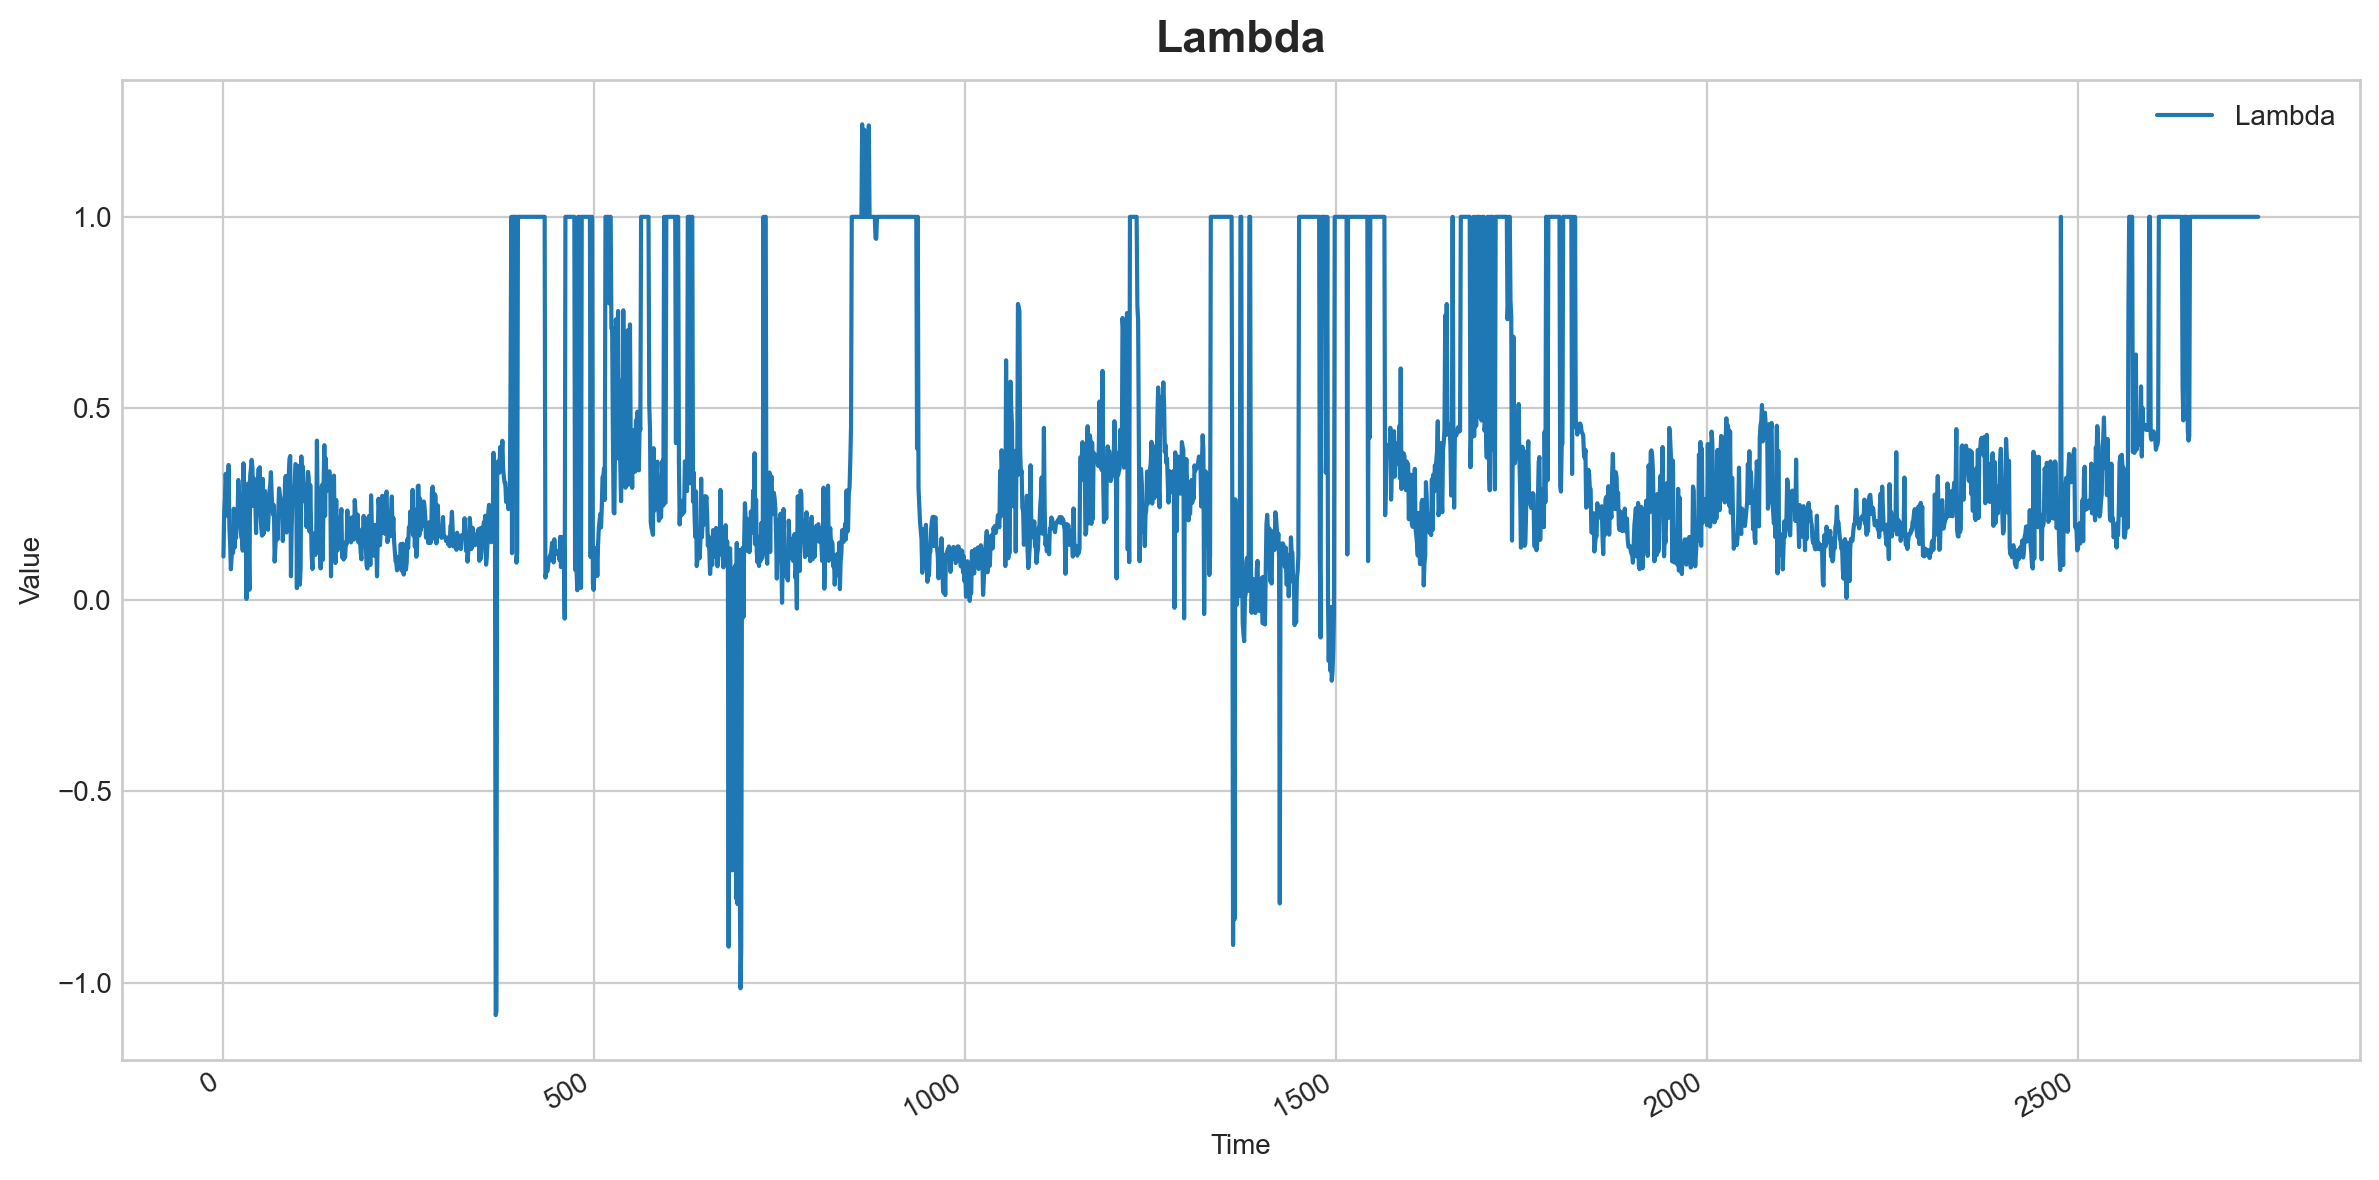

In [16]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(lambda_value_list, label="Lambda")


ax.set_title("Lambda")
ax.set_xlabel("Time")
ax.set_ylabel("Value")
fig.autofmt_xdate()
plt.tight_layout()
plt.legend(loc=1)

In [17]:
const_lambda_value = np.mean(lambda_value_list)
const_lambda_value

0.38571105410008855

In [18]:
# 计算因子载荷
# 

tau = const_lambda_value
T_list = np.linspace(0.0, 30.0, 100)
beta0_loading_list = []
beta1_loading_list = []
beta2_loading_list = []

for T in T_list:
    beta0_loading = 1
    exp_tt0 = np.exp(-T * tau)
    beta1_loading = (1 - exp_tt0) / (T * tau)
    beta2_loading = beta1_loading - exp_tt0
    
    beta0_loading_list.append(beta0_loading)
    beta1_loading_list.append(beta1_loading)
    beta2_loading_list.append(beta2_loading)

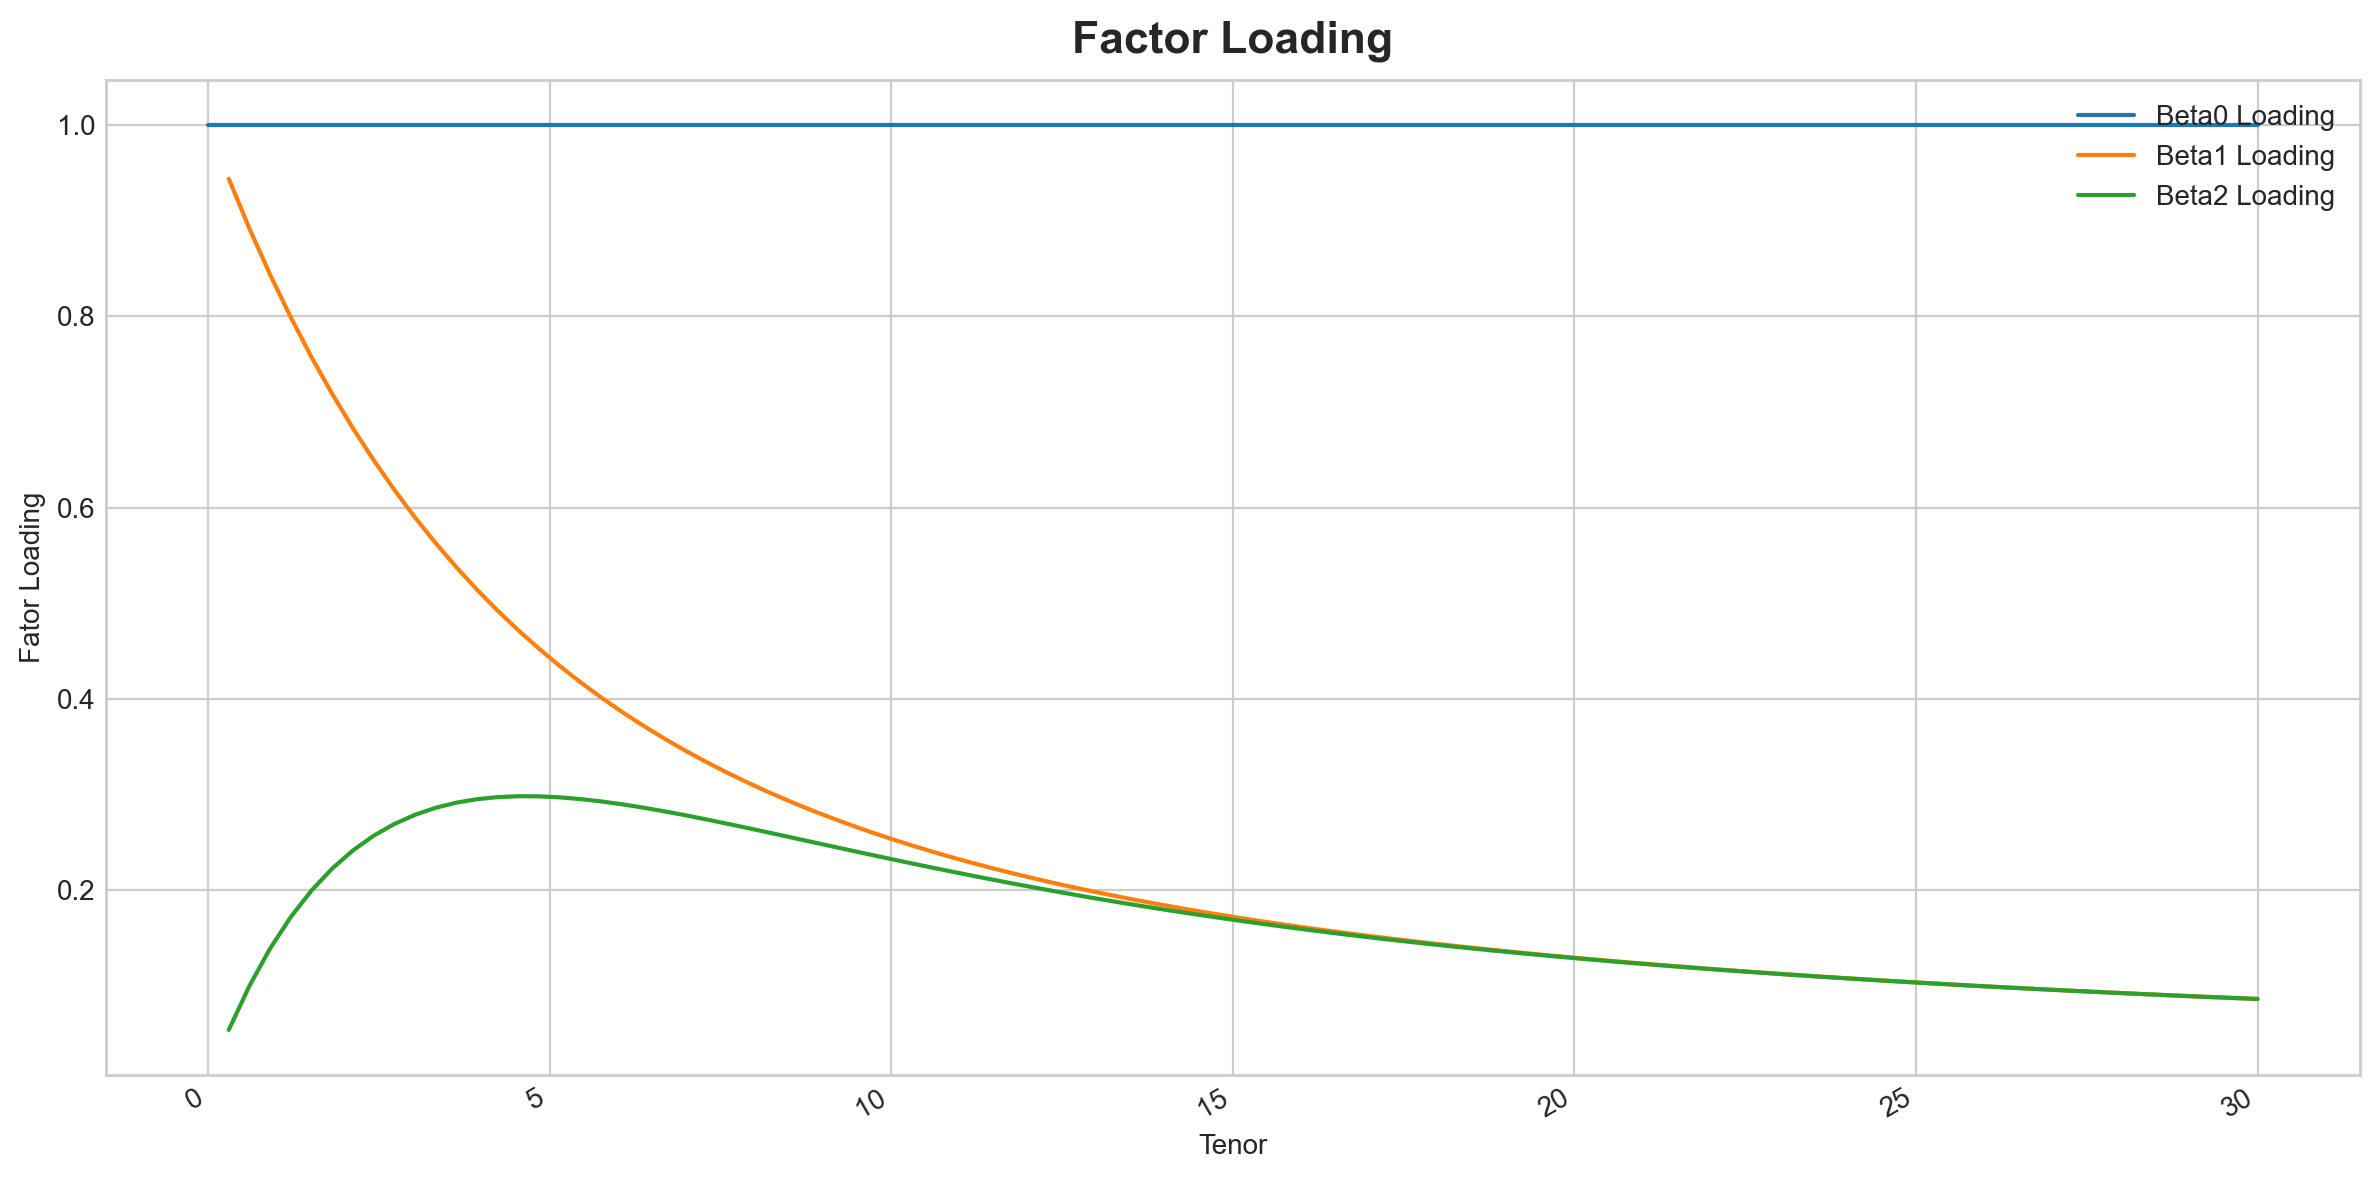

In [19]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(T_list, beta0_loading_list, label="Beta0 Loading")
ax.plot(T_list, beta1_loading_list, label="Beta1 Loading")
ax.plot(T_list, beta2_loading_list, label="Beta2 Loading")


ax.set_title("Factor Loading")
ax.set_xlabel("Tenor")
ax.set_ylabel("Fator Loading")
fig.autofmt_xdate()
plt.tight_layout()
plt.legend(loc=1)

## 5. 构建DNS因子

In [21]:
date_list = []
beta0_list = []
beta1_list = []
beta2_list = []
tau_list = []

# 获取模型值
model_ytm_df = pd.DataFrame(columns= yield_to_maturity_df.columns)

for i in range(yield_to_maturity_df.shape[0]):
    date = yield_to_maturity_df['Date'][i]
    time_list = [0.50, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30]
    tenor_list = ['6M', '1Y', '2Y', '3Y', '4Y', '5Y', '6Y', '7Y', 
                  '8Y', '9Y', '10Y', '15Y', '20Y', '30Y']
    ytm_list = yield_to_maturity_df[yield_to_maturity_df['Date']==date][tenor_list].values.tolist()[0]
    ytm_list = [var/100 for var in ytm_list]
    t = np.array(time_list)
    y = np.array(ytm_list)
    curve, stsq_res = betas_ns_ols(const_lambda_value, t, y)
    
    model_value_list = [date]
    for temp_time in time_list:
        temp_time_value = curve(temp_time) * 100
        model_value_list.append(temp_time_value)
        
    model_ytm_df.loc[len(model_ytm_df.index)] = model_value_list
    
    #if stsq_res[0] == True:
    beat0 = curve.beta0
    beat1 = curve.beta1
    beat2 = curve.beta2
    tau = curve.tau

    date_list.append(date)
    beta0_list.append(beat0)
    beta1_list.append(beat1)
    beta2_list.append(beat2)
    tau_list.append(tau)
        


In [22]:
dns_curve_df = pd.DataFrame()

dns_curve_df['Date'] = date_list
dns_curve_df['Beta0'] = beta0_list
dns_curve_df['Beta1'] = beta1_list
dns_curve_df['Beta2'] = beta2_list
dns_curve_df['Tau'] = tau_list
dns_curve_df

,Date,Beta0,Beta1,Beta2,Tau
0,2012-01-04,0.043742,-0.017076,-0.018349,0.385711
1,2012-01-05,0.043450,-0.017049,-0.016695,0.385711
2,2012-01-06,0.043353,-0.016882,-0.016428,0.385711
3,2012-01-09,0.042846,-0.016354,-0.015826,0.385711
4,2012-01-10,0.043009,-0.016888,-0.014964,0.385711
...,...,...,...,...,...
2739,2022-12-26,0.033076,-0.011927,-0.005001,0.385711
2740,2022-12-27,0.033007,-0.011684,-0.004015,0.385711
2741,2022-12-28,0.033041,-0.011471,-0.004345,0.385711
2742,2022-12-29,0.032831,-0.012076,-0.003824,0.385711


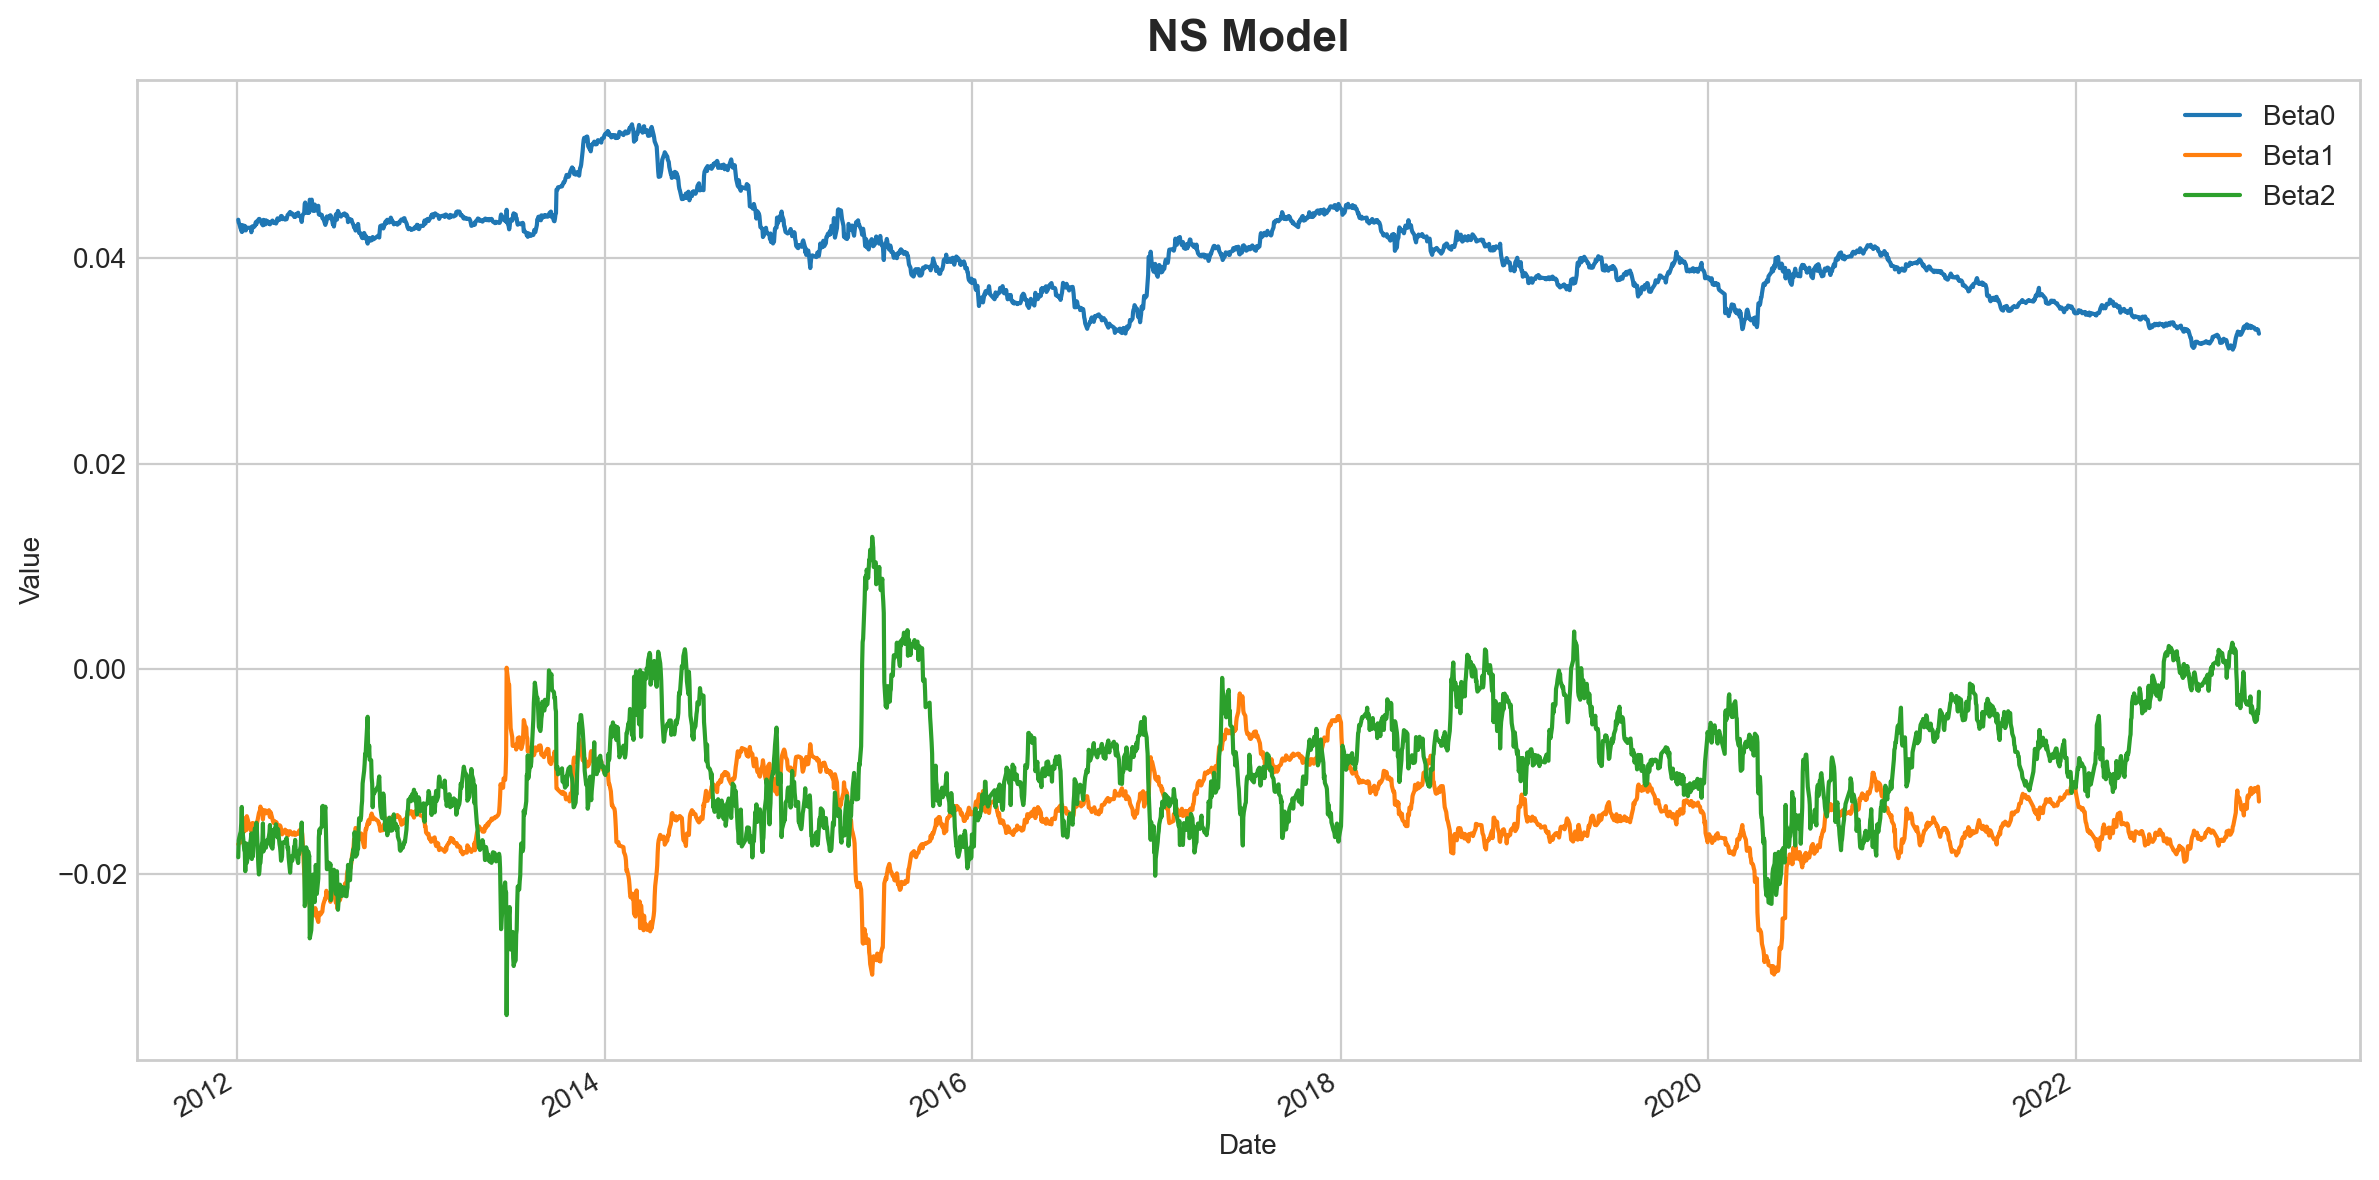

In [23]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(dns_curve_df['Date'], dns_curve_df['Beta0'], label="Beta0")
ax.plot(dns_curve_df['Date'], dns_curve_df['Beta1'], label="Beta1")
ax.plot(dns_curve_df['Date'], dns_curve_df['Beta2'], label="Beta2")
#ax.plot(curve_df['Date'], curve_df['Tau'], label="Tau")

ax.set_title("NS Model")
ax.set_xlabel("Date")
ax.set_ylabel("Value")
fig.autofmt_xdate()
plt.tight_layout()
plt.legend(loc=1)

In [24]:
dns_curve_df.to_csv("./data/dns_factor.csv", index=False, encoding="utf-8-sig")

In [25]:
yield_to_maturity_df.to_csv("./data/ytm_data.csv", index=False, encoding="utf-8-sig")

## 6. 模型值和真实值


In [26]:
model_ytm_df

,Date,6M,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y,10Y,15Y,20Y,30Y
0,2012-01-04,2.665505,2.682664,2.753694,2.852167,2.961270,3.071115,3.176190,3.273706,3.362530,3.442500,3.513996,3.769479,3.916059,4.068126
1,2012-01-05,2.652722,2.680401,2.765113,2.870507,2.982316,3.092309,3.196041,3.291408,3.377701,3.455021,3.523902,3.768673,3.908501,4.053384
2,2012-01-06,2.660431,2.688514,2.773281,2.878099,2.989001,3.097940,3.200585,3.294893,3.380191,3.456596,3.524645,3.766368,3.904414,4.047440
3,2012-01-09,2.662862,2.690635,2.773493,2.875412,2.982999,3.088547,3.187917,3.279167,3.361667,3.435544,3.501329,3.734934,3.868309,4.006485
4,2012-01-10,2.637993,2.675616,2.772876,2.884123,2.997662,3.106926,3.208542,3.301076,3.384242,3.458390,3.524201,3.756687,3.888885,4.025682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2739,2022-12-26,2.180359,2.243047,2.358972,2.461774,2.551816,2.630083,2.697821,2.756338,2.806888,2.850613,2.888526,3.017419,3.088455,3.161289
2740,2022-12-27,2.204023,2.271169,2.392231,2.496784,2.586553,2.663396,2.729111,2.785347,2.833564,2.875023,2.910800,3.031452,3.097489,3.165058
2741,2022-12-28,2.224025,2.287330,2.402763,2.503654,2.591071,2.666432,2.731239,2.786944,2.834874,2.876203,2.911948,3.032954,3.099403,3.167461
2742,2022-12-29,2.152341,2.223857,2.351752,2.461236,2.554598,2.634087,2.701774,2.759500,2.808858,2.851204,2.887682,3.010322,3.077271,3.145718


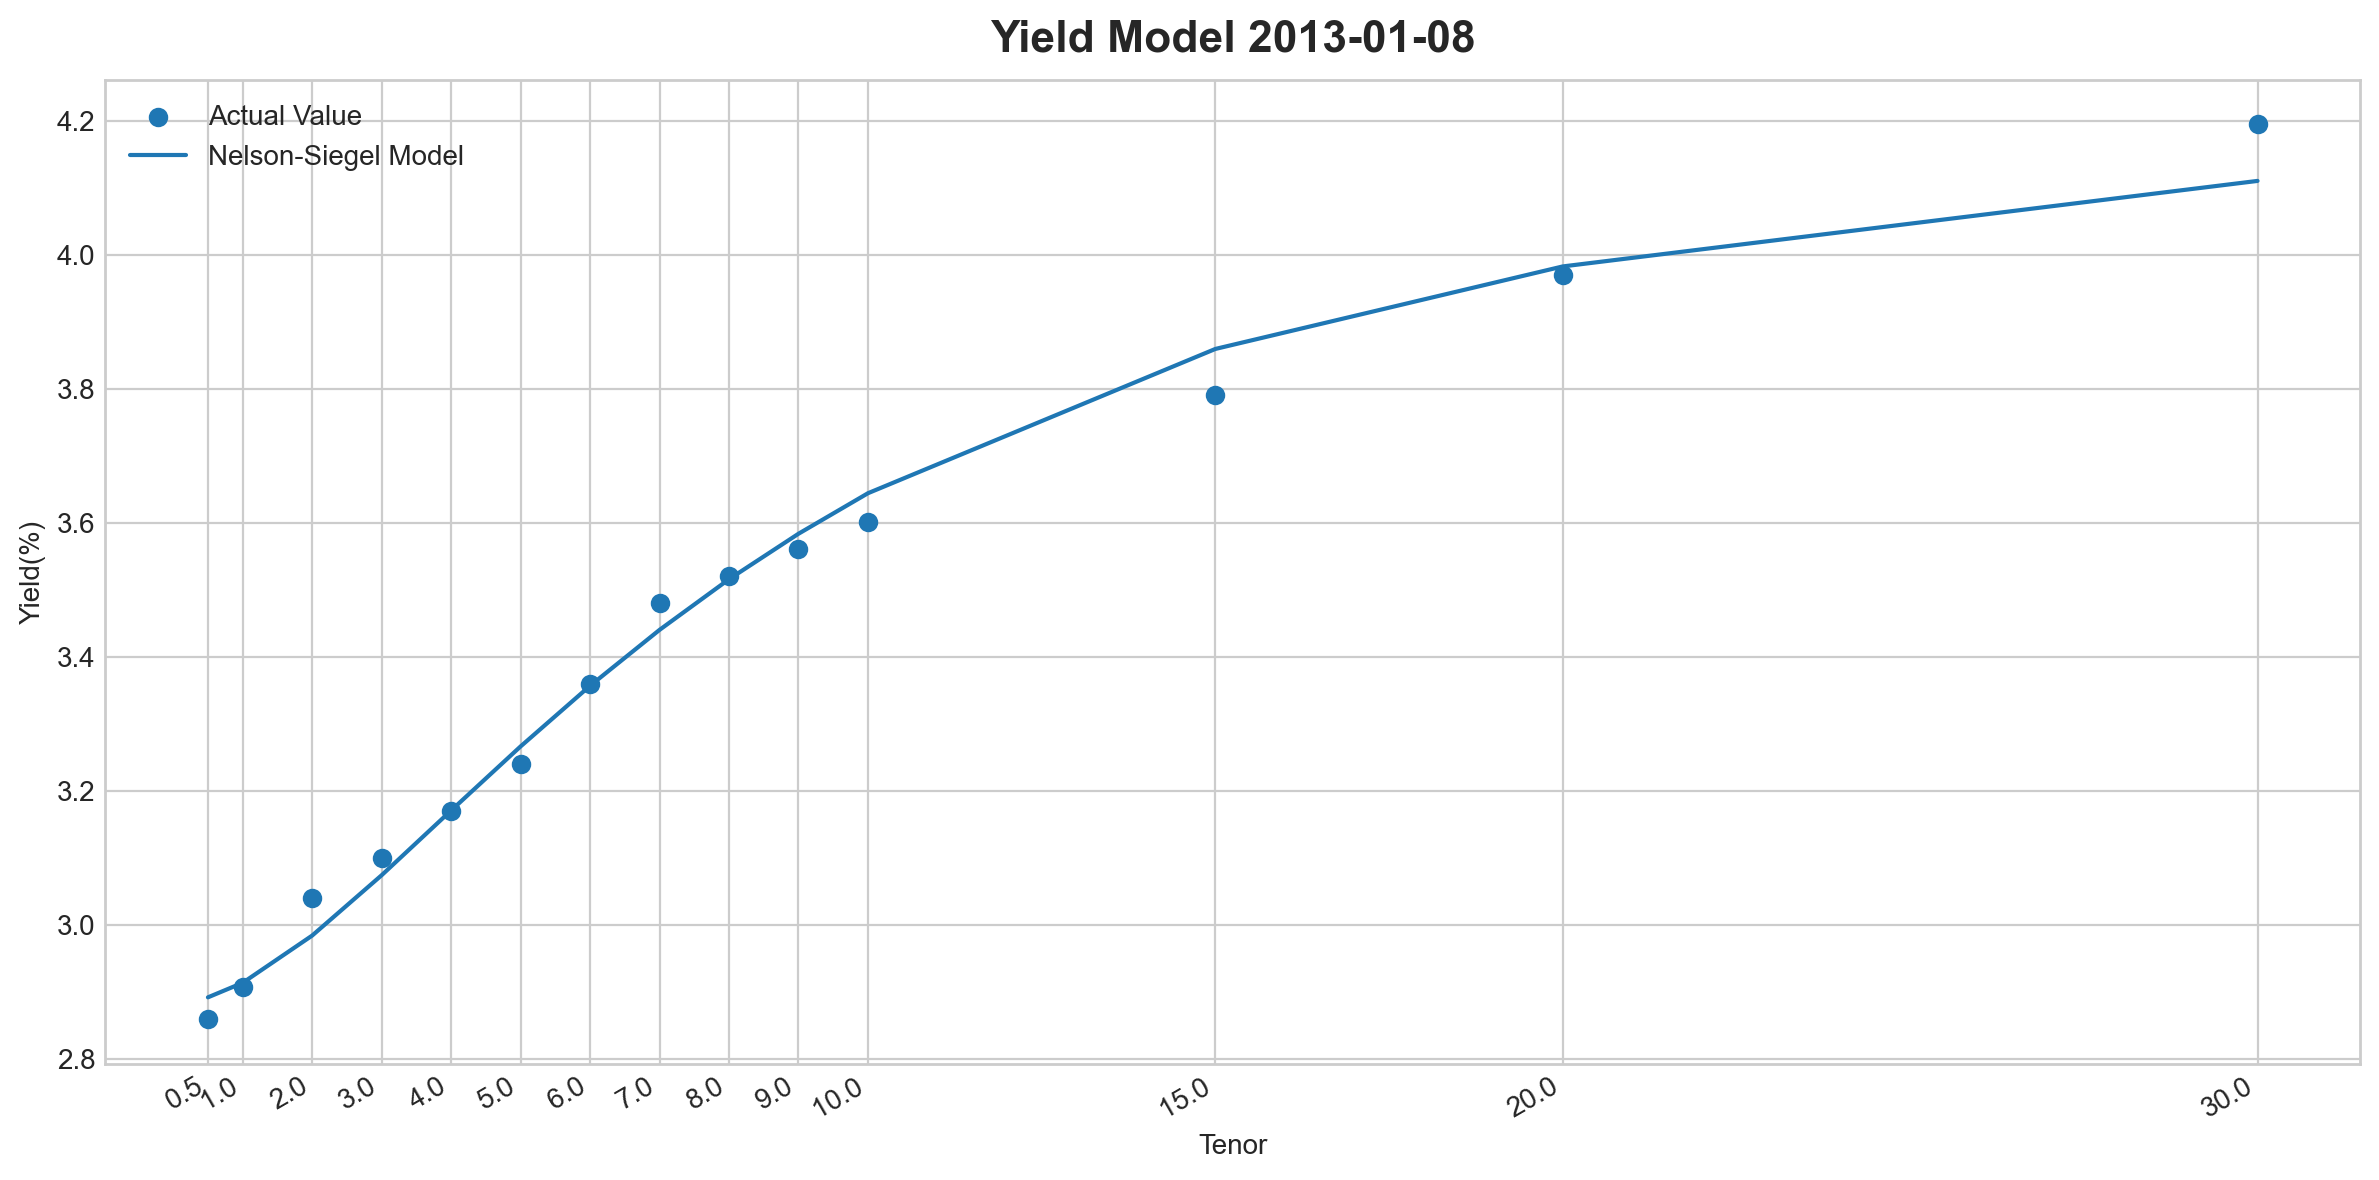

In [34]:
# 选择某一天
test_date_str = "2013-01-08"
test_date =  datetime.datetime.strptime(test_date_str, "%Y-%m-%d")

fig, ax = plt.subplots(figsize=(12, 6))
time_list = [0.50, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30]
tenor_list = ['6M', '1Y', '2Y', '3Y', '4Y', '5Y', '6Y', '7Y', 
              '8Y', '9Y', '10Y', '15Y', '20Y', '30Y']

temp_actual_ytm_df = yield_to_maturity_df[yield_to_maturity_df['Date']==test_date][tenor_list]
temp_actual_ytm_list = temp_actual_ytm_df.values[0]



temp_bootstrap_ytm_df = model_ytm_df[model_ytm_df['Date']==test_date][tenor_list]
temp_bootstrap_ytm_list = temp_bootstrap_ytm_df.values[0]


ax.scatter(time_list, temp_actual_ytm_list, label="Actual Value")
ax.plot(time_list, temp_bootstrap_ytm_list, label="Nelson-Siegel Model")


plt.xticks(time_list)


ax.set_title("Yield Model " + test_date_str)
ax.set_xlabel("Tenor")
ax.set_ylabel("Yield(%)")
fig.autofmt_xdate()
plt.tight_layout()
plt.legend(loc=2)

In [27]:
# 计算MAPE:平均绝对百分比误差
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred)/y_true)) * 100

In [28]:
# 因子预测分析： 计算MAE(平均绝对误差), MAPE(平均绝对百分比误差)， RMSE(均方根误差)的值
def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

In [29]:
# 均方根误差
import math
def rmse(y_true, y_pred):
    MSE = np.square(np.subtract(y_true,y_pred)).mean() 
    RMSE = math.sqrt(MSE)
    return RMSE

In [30]:
columns_list = ['6M', '1Y', '2Y', '3Y', '4Y', '5Y', '6Y', '7Y', '8Y', '9Y', '10Y', '15Y', '20Y', '30Y']
mae_list = []
mape_list = []
rmse_list = []
for temp_column in columns_list:
    #print(temp_column)
    temp_mae = mae(yield_to_maturity_df[temp_column], model_ytm_df[temp_column])
    temp_mape = mape(yield_to_maturity_df[temp_column], model_ytm_df[temp_column])
    temp_rmse =  rmse(yield_to_maturity_df[temp_column], model_ytm_df[temp_column]) * 100
    mae_list.append(temp_mae)
    mape_list.append(temp_mape)
    rmse_list.append(temp_rmse)

error_df = pd.DataFrame()
error_df['Tenor'] = columns_list
error_df['MAE'] = mae_list
error_df['MAPE'] = mape_list
error_df['RMSE'] = rmse_list
error_df

,Tenor,MAE,MAPE,RMSE
0,6M,0.058132,2.369907,7.149678
1,1Y,0.037827,1.479806,5.022071
2,2Y,0.060792,2.197342,7.061266
3,3Y,0.051251,1.743392,5.957533
4,4Y,0.029813,0.974663,3.537312
5,5Y,0.024822,0.789630,3.190060
6,6Y,0.017437,0.555267,2.117551
7,7Y,0.030553,0.977646,3.861582
8,8Y,0.031908,0.965580,3.728202
9,9Y,0.074981,2.297570,8.043113


In [31]:
# 保存真实值
yield_to_maturity_df.to_csv('./data/CN_DNS_Real_Yield.csv', index=False, encoding="utf-8-sig")

# 保存模型值
model_ytm_df.to_csv('./data/CN_DNS_Model_Yield.csv', index=False, encoding="utf-8-sig")

# 保存模型值与真实值的误差
error_df.to_csv('./data/DNS_Compare.csv', index=False, encoding="utf-8-sig")

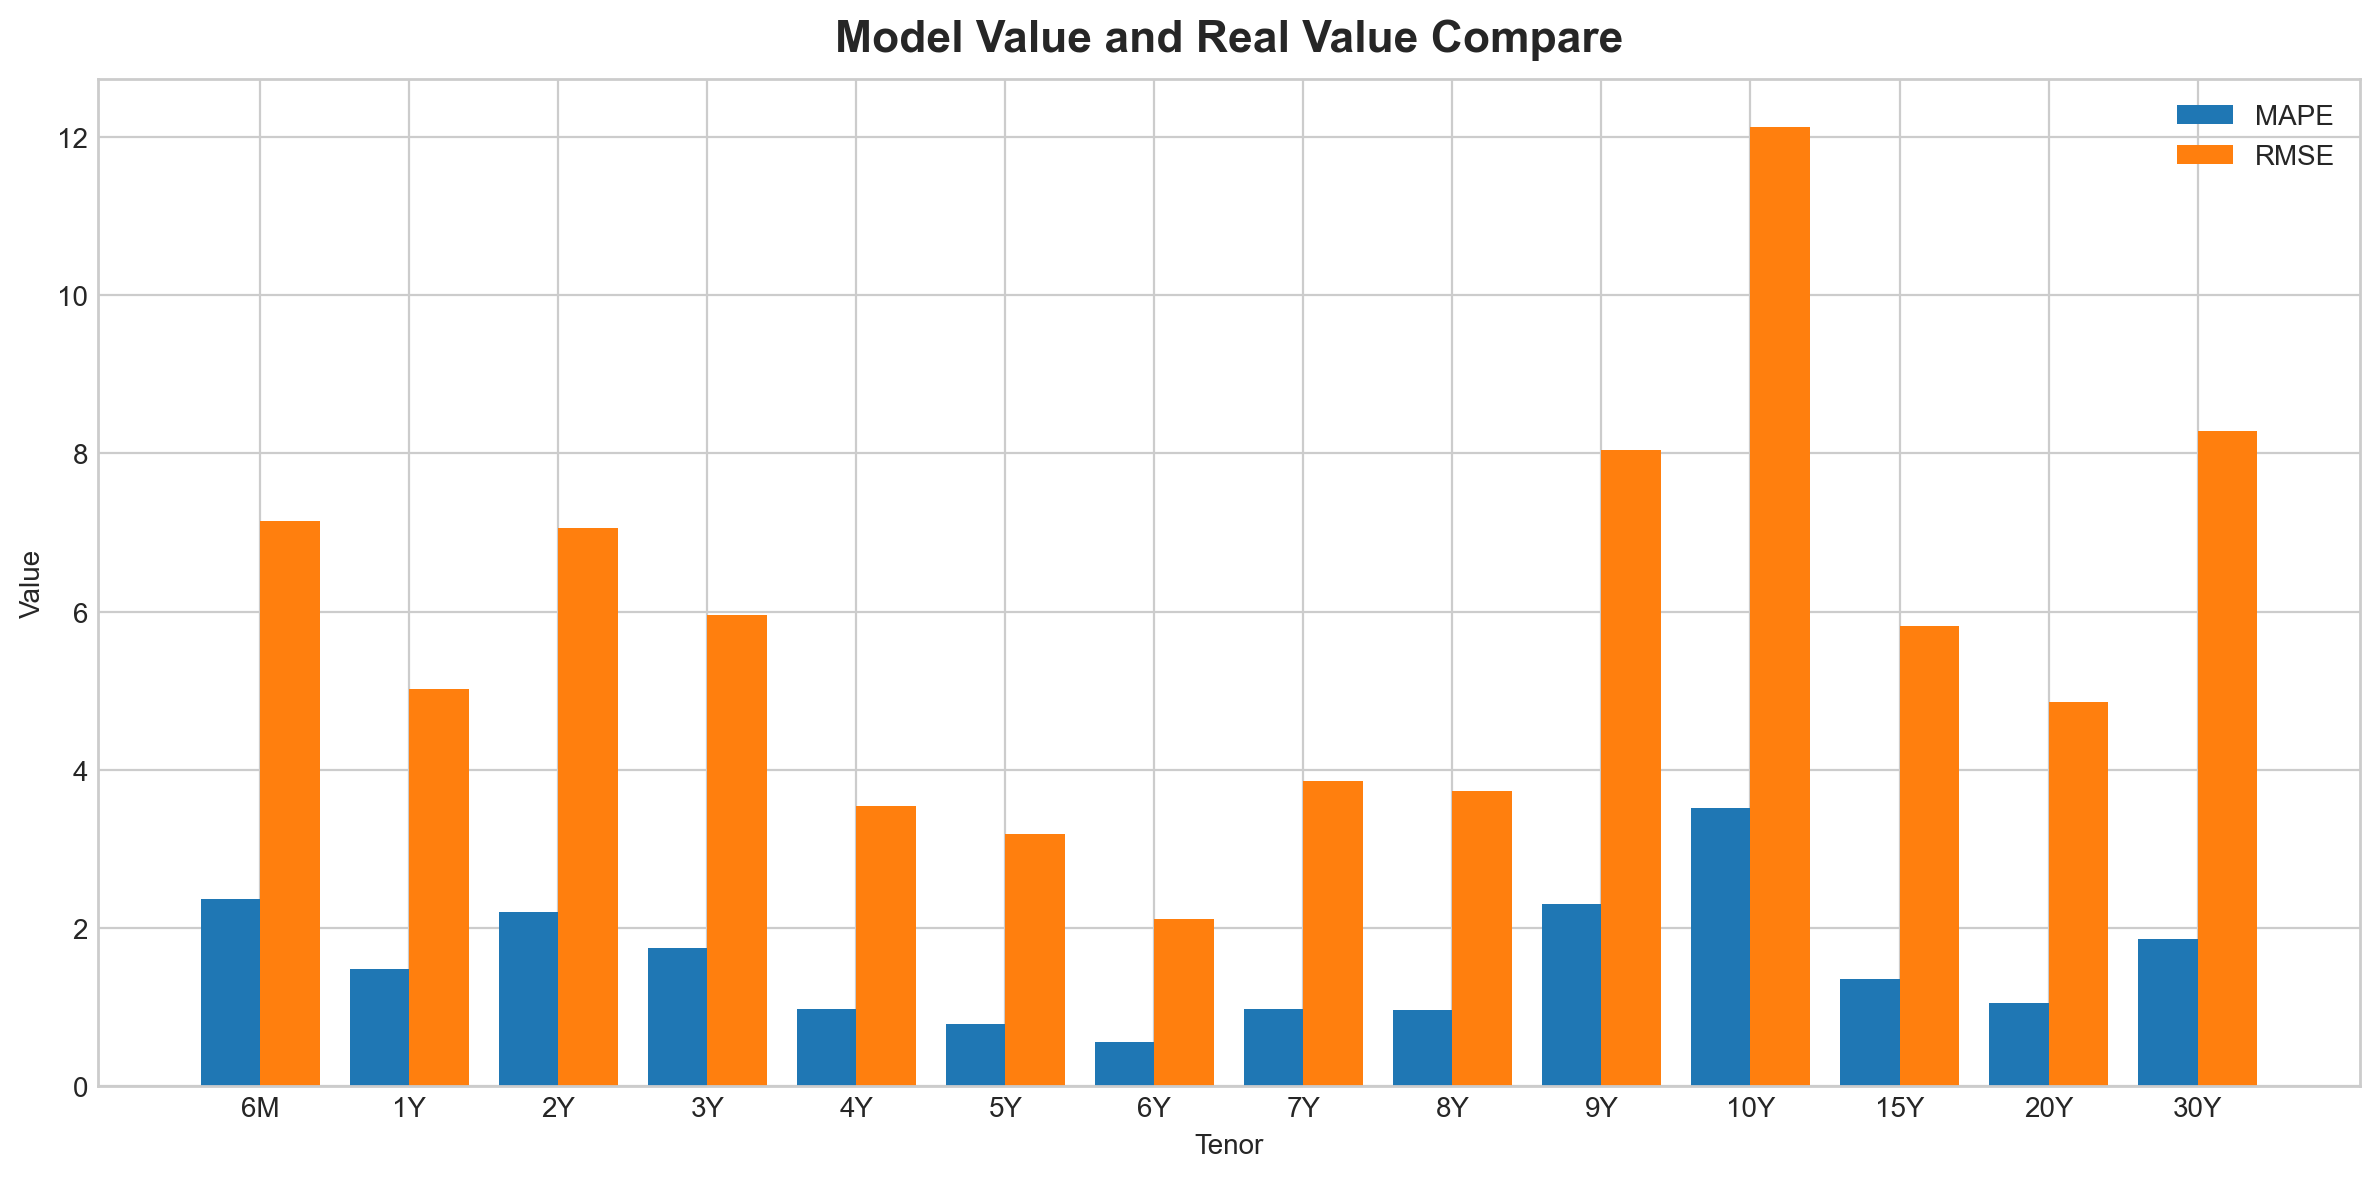

In [32]:
# 可视化误差
fig, ax = plt.subplots(figsize=(12, 6))

totalWidth=0.8 # 一组柱状体的宽度
labelNums=2 # 一组有两种类别
barWidth=totalWidth/labelNums # 单个柱体的宽度
seriesNums=error_df.shape[0] # 一共有多少组

ax.bar([x for x in range(seriesNums)], error_df['MAPE'], label="MAPE", width=barWidth)
ax.bar([x+barWidth for x in range(seriesNums)], error_df['RMSE'], label="RMSE", width=barWidth)

plt.xticks([x+barWidth/2*(labelNums-1) for x in range(seriesNums)], error_df['Tenor'])
plt.xlabel("Tenor")
plt.ylabel("Value")
plt.title("Model Value and Real Value Compare")
plt.legend()
plt.show()



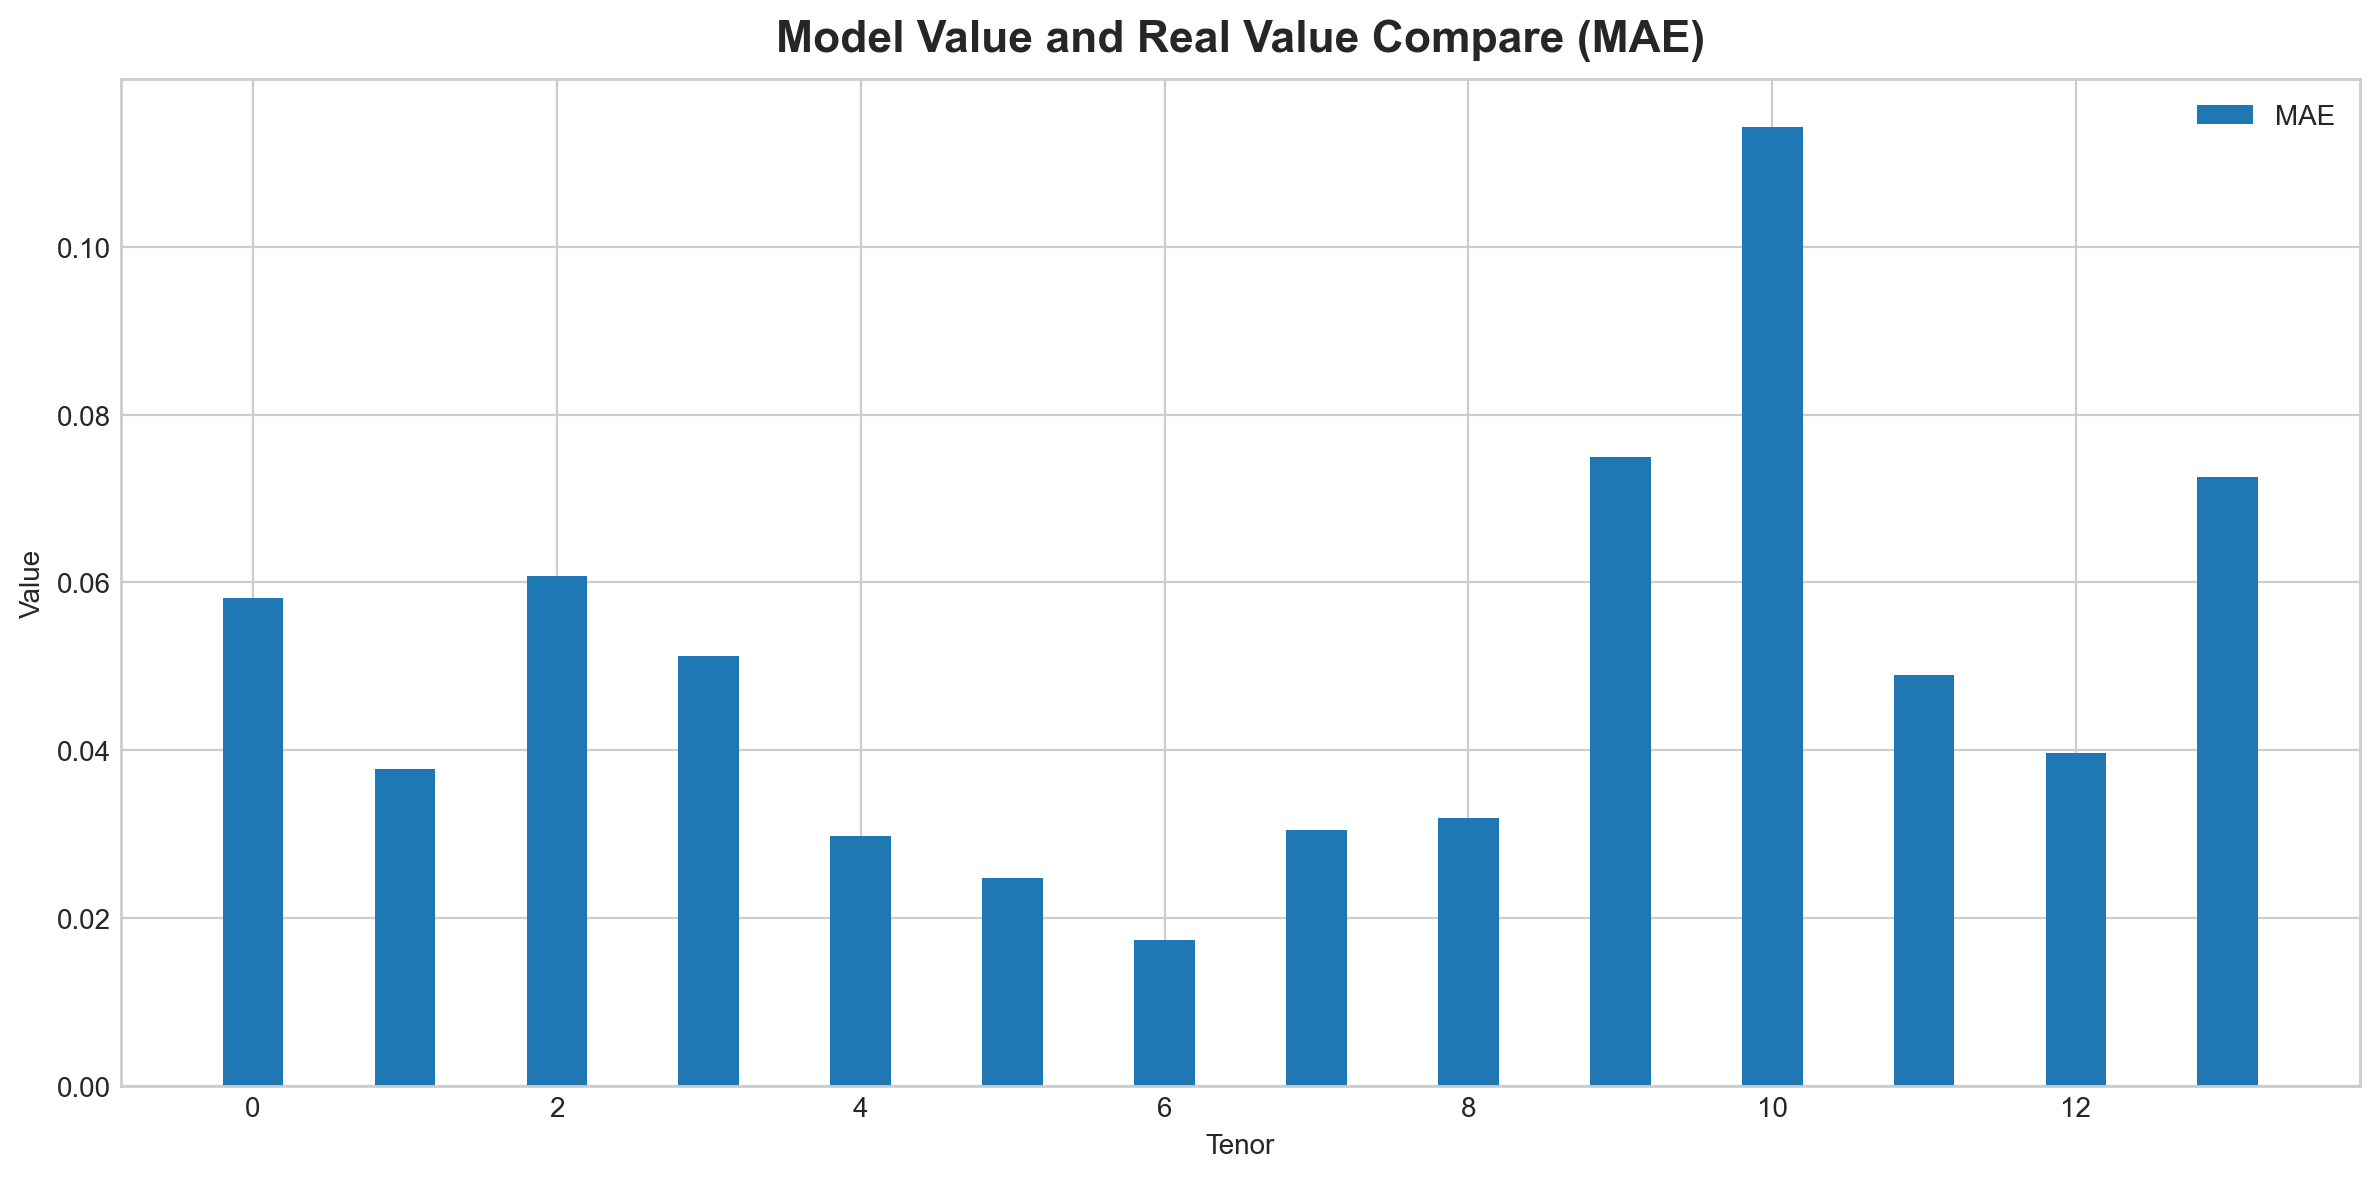

In [35]:
# 可视化误差
fig, ax = plt.subplots(figsize=(12, 6))

totalWidth=0.8 # 一组柱状体的宽度
labelNums=2 # 一组有两种类别
barWidth=totalWidth/labelNums # 单个柱体的宽度
seriesNums=error_df.shape[0] # 一共有多少组

ax.bar([x for x in range(seriesNums)], error_df['MAE'], label="MAE", width=barWidth)
#ax.bar([x+barWidth for x in range(seriesNums)], error_df['RMSE'], label="RMSE", width=barWidth)

#plt.xticks([x+barWidth/2*(labelNums-1) for x in range(seriesNums)], error_df['Tenor'])
plt.xlabel("Tenor")
plt.ylabel("Value")
plt.title("Model Value and Real Value Compare (MAE)")
plt.legend()
plt.show()

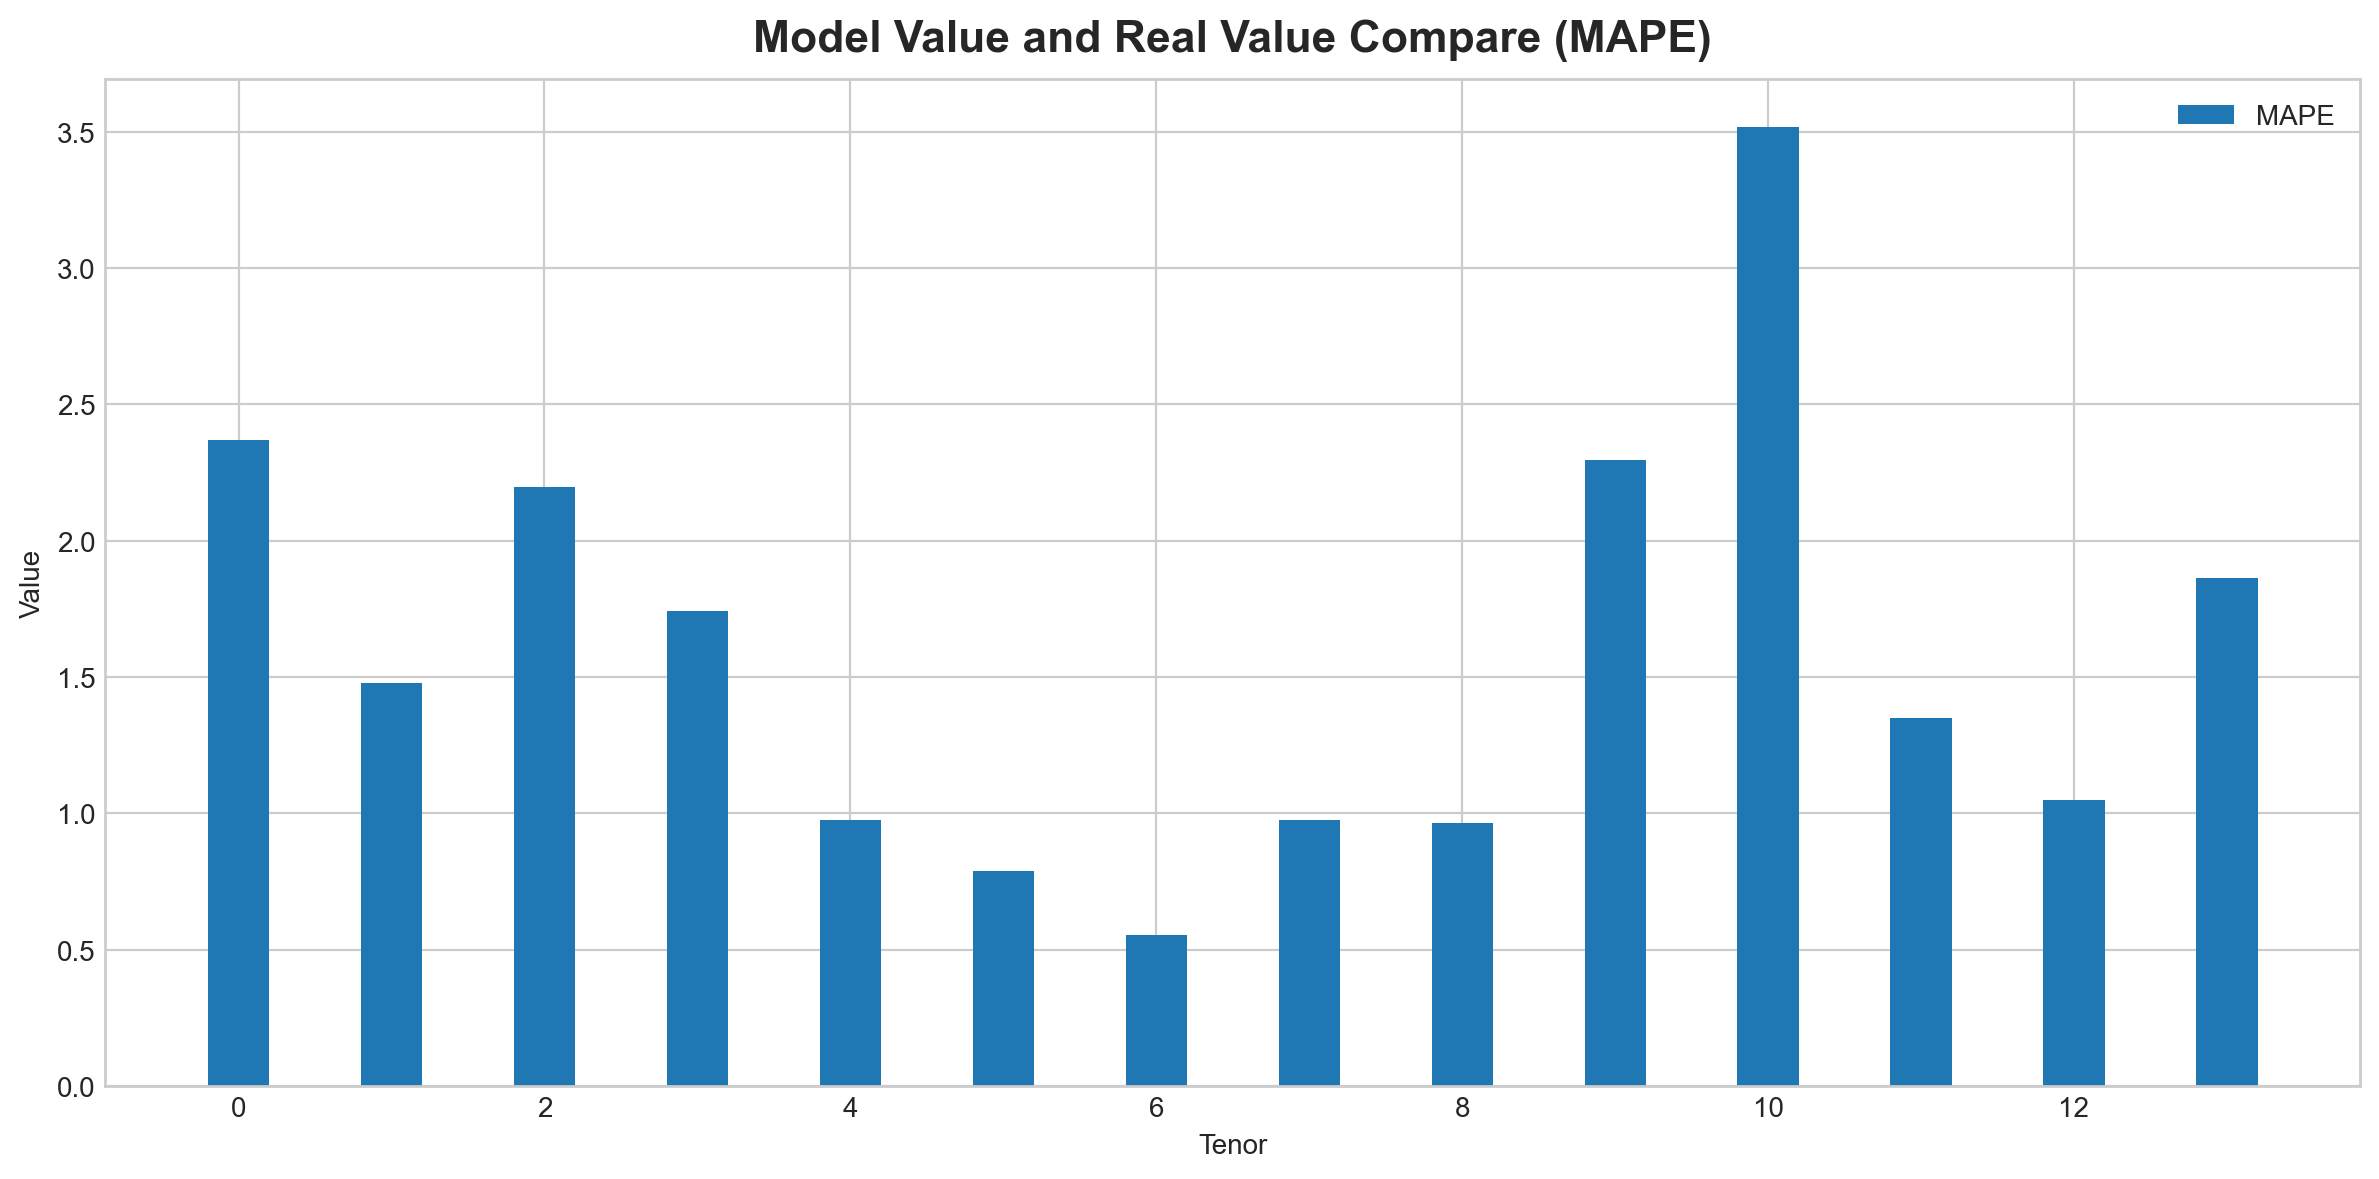

In [36]:
# 可视化误差
fig, ax = plt.subplots(figsize=(12, 6))

totalWidth=0.8 # 一组柱状体的宽度
labelNums=2 # 一组有两种类别
barWidth=totalWidth/labelNums # 单个柱体的宽度
seriesNums=error_df.shape[0] # 一共有多少组

ax.bar([x for x in range(seriesNums)], error_df['MAPE'], label="MAPE", width=barWidth)
#ax.bar([x+barWidth for x in range(seriesNums)], error_df['RMSE'], label="RMSE", width=barWidth)

#plt.xticks([x+barWidth/2*(labelNums-1) for x in range(seriesNums)], error_df['Tenor'])
plt.xlabel("Tenor")
plt.ylabel("Value")
plt.title("Model Value and Real Value Compare (MAPE)")
plt.legend()
plt.show()

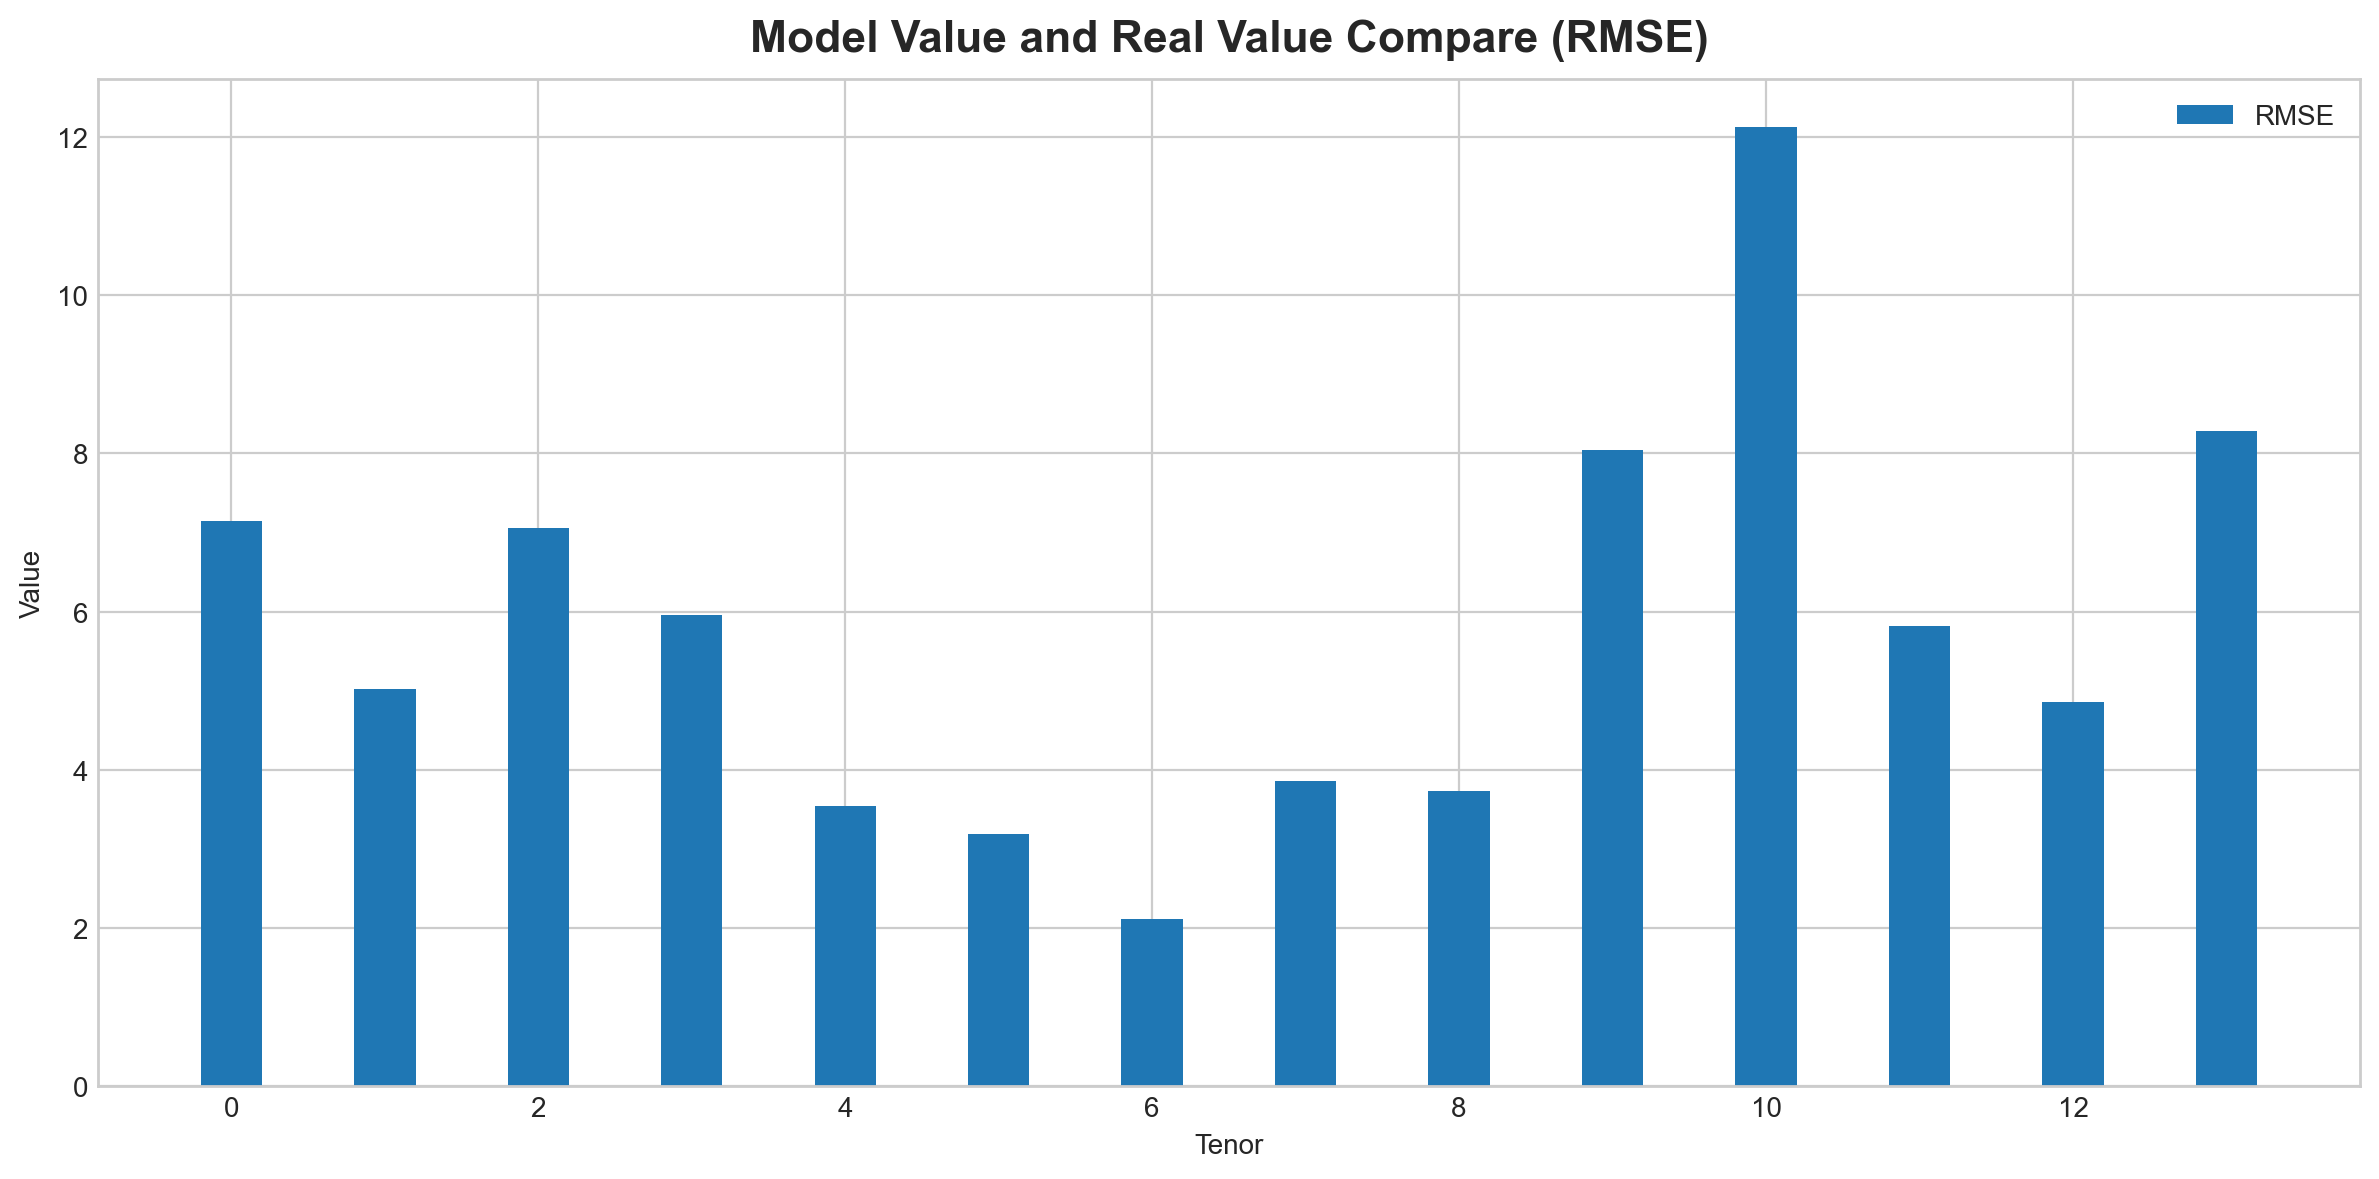

In [37]:
# 可视化误差
fig, ax = plt.subplots(figsize=(12, 6))

totalWidth=0.8 # 一组柱状体的宽度
labelNums=2 # 一组有两种类别
barWidth=totalWidth/labelNums # 单个柱体的宽度
seriesNums=error_df.shape[0] # 一共有多少组

ax.bar([x for x in range(seriesNums)], error_df['RMSE'], label="RMSE", width=barWidth)
#ax.bar([x+barWidth for x in range(seriesNums)], error_df['RMSE'], label="RMSE", width=barWidth)

#plt.xticks([x+barWidth/2*(labelNums-1) for x in range(seriesNums)], error_df['Tenor'])
plt.xlabel("Tenor")
plt.ylabel("Value")
plt.title("Model Value and Real Value Compare (RMSE)")
plt.legend()
plt.show()